# 📊 Tarea de Regresión Lineal

**Estudiante:** Diego Miranda  
**Conjunto de Datos:** *Global Air Quality* (Enero 2024 – Enero 2025) – Londres  
**Fuente del Dataset:** [Youssef Elebiary – Kaggle](https://www.kaggle.com/datasets/youssefelebiary/global-air-quality)
---

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.express as px

# Análisis
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
import pingouin as pg  # Para correlación parcial

import gc
import pingouin as pg
# Estilo
sns.set(style="whitegrid")

In [2]:
df = pd.read_csv("London_Air_Quality.csv")
df_anterior = df.shape
# df = df.dropna(subset=["NO2", "PM10", "PM2.5", "O3", "CO", "SO2","CO2","AQI"])
print("Comparativa antes y después de eliminar NaN: ", df_anterior, "->", df.shape)
# Convertir la columna de fecha a tipo datetime
df['Date'] = pd.to_datetime(df['Date'], utc=True)
# Establecer la columna de fecha como índice
df.set_index('Date', inplace=True)
df.head()

Comparativa antes y después de eliminar NaN:  (8784, 9) -> (8784, 9)


,CO,CO2,NO2,SO2,O3,PM2.5,PM10,AQI
Date,,,,,,,,
2024-01-01 00:00:00+00:00,162.0,NaN,4.7,1.0,65.0,3.5,7.3,9.070833
2024-01-01 01:00:00+00:00,163.0,NaN,4.6,1.2,63.0,3.5,6.0,25.200000
2024-01-01 02:00:00+00:00,157.0,NaN,4.3,1.1,64.0,3.3,5.9,25.599998
2024-01-01 03:00:00+00:00,156.0,NaN,4.4,1.1,64.0,3.1,5.7,25.599998
2024-01-01 04:00:00+00:00,157.0,NaN,4.6,1.1,65.0,2.9,5.7,26.000000


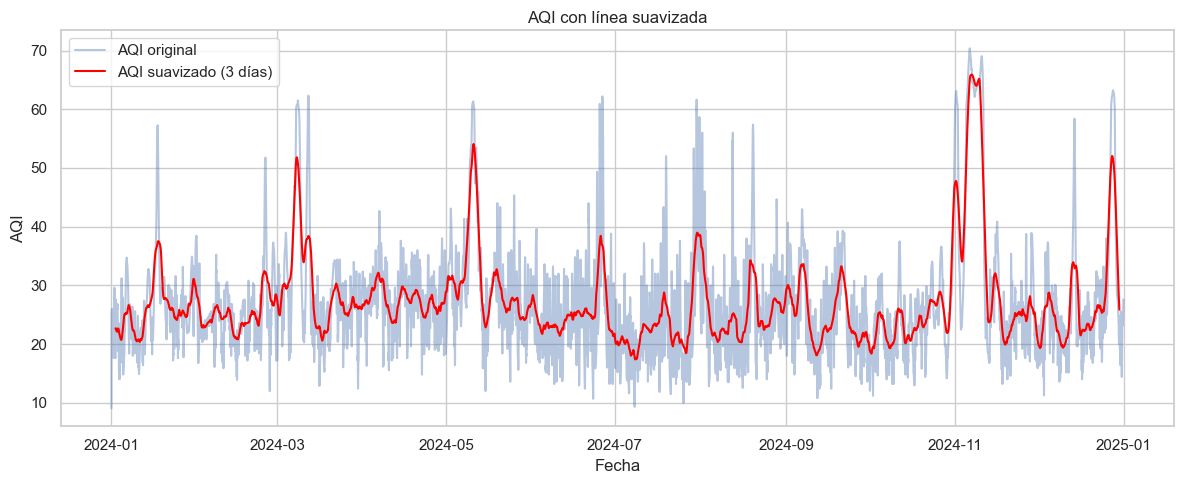

3408

In [3]:
df1 = df.copy()
df1['AQI_smooth'] = df['AQI'].rolling(window=24*3, center=True).mean()  # promedio móvil de 3 días si es horario

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(df1.index, df1['AQI'], label='AQI original', alpha=0.4)
plt.plot(df1.index, df1['AQI_smooth'], label='AQI suavizado (3 días)', color='red')
plt.xlabel('Fecha')
plt.ylabel('AQI')
plt.title('AQI con línea suavizada')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

del df1
gc.collect()

In [4]:
df1 = df.copy()
df1['Mes'] = df1.index.to_period('M')

# Contar cuántos registros hay por mes
conteo_mensual = df1['Mes'].value_counts().sort_index()

# Mostrar resultados
print(conteo_mensual)
del df1
gc.collect()

Mes
2024-01    744
2024-02    696
2024-03    744
2024-04    720
2024-05    744
2024-06    720
2024-07    744
2024-08    744
2024-09    720
2024-10    744
2024-11    720
2024-12    744
Freq: M, Name: count, dtype: int64


C:\Users\diego\AppData\Local\Temp\ipykernel_9736\2456335874.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df1['Mes'] = df1.index.to_period('M')


0

# Análisis del impacto del CO2 en el modelo

In [5]:
df_co2 = df.dropna(subset=["CO2"]).dropna()
df_no_co2 = df.drop(columns=["CO2"])  
X_co2 = df_co2.drop(columns=["AQI"])
y_co2 = df_co2["AQI"]
X_no_co2 = df_no_co2.drop(columns=["AQI"])
y_no_co2 = df_no_co2["AQI"]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Modelo con CO2
model_co2 = LinearRegression().fit(X_co2, y_co2)
preds_co2 = model_co2.predict(X_co2)

# Modelo sin CO2 
X_no_co2_sample = X_no_co2.loc[df_co2.index]
y_no_co2_sample = y_no_co2.loc[df_co2.index]

model_no_co2 = LinearRegression().fit(X_no_co2_sample, y_no_co2_sample)
preds_no_co2 = model_no_co2.predict(X_no_co2_sample)

print("Modelo con CO2:")
print("R2:", r2_score(y_co2, preds_co2))
print("RMSE:", np.sqrt(mean_squared_error(y_co2, preds_co2)))

print("\nModelo sin CO2:")
print("R2:", r2_score(y_no_co2_sample, preds_no_co2))
print("RMSE:", np.sqrt(mean_squared_error(y_no_co2_sample, preds_no_co2)))

df_full = df.drop(columns=["CO2"]).dropna()

# Define variables predictoras y objetivo
X_full = df_full.drop(columns=["AQI"])
y_full = df_full["AQI"]

# Ajusta el modelo
model_full = LinearRegression().fit(X_full, y_full)
preds_full = model_full.predict(X_full)

# Evalúa desempeño
print("Modelo sin CO2 (datos completos):")
print("R2:", r2_score(y_full, preds_full))
print("RMSE:", np.sqrt(mean_squared_error(y_full, preds_full)))
del df_co2, df_no_co2, X_co2, y_co2, X_no_co2, y_no_co2
del X_no_co2_sample, y_no_co2_sample, model_co2, model_no_co2, preds_co2, preds_no_co2
del model_full, preds_full
gc.collect()

Modelo con CO2:
R2: 0.7027435932079771
RMSE: 8.121282699038145

Modelo sin CO2:
R2: 0.7009726805859329
RMSE: 8.145438150149365
Modelo sin CO2 (datos completos):
R2: 0.497370131998913
RMSE: 7.069230041469949


0

=== Correlación Pearson con AQI ===
AQI      1.000000
PM2.5    0.796162
PM10     0.777979
CO       0.640347
SO2      0.615842
NO2      0.458779
CO2      0.408765
O3      -0.504947
Name: AQI, dtype: float64


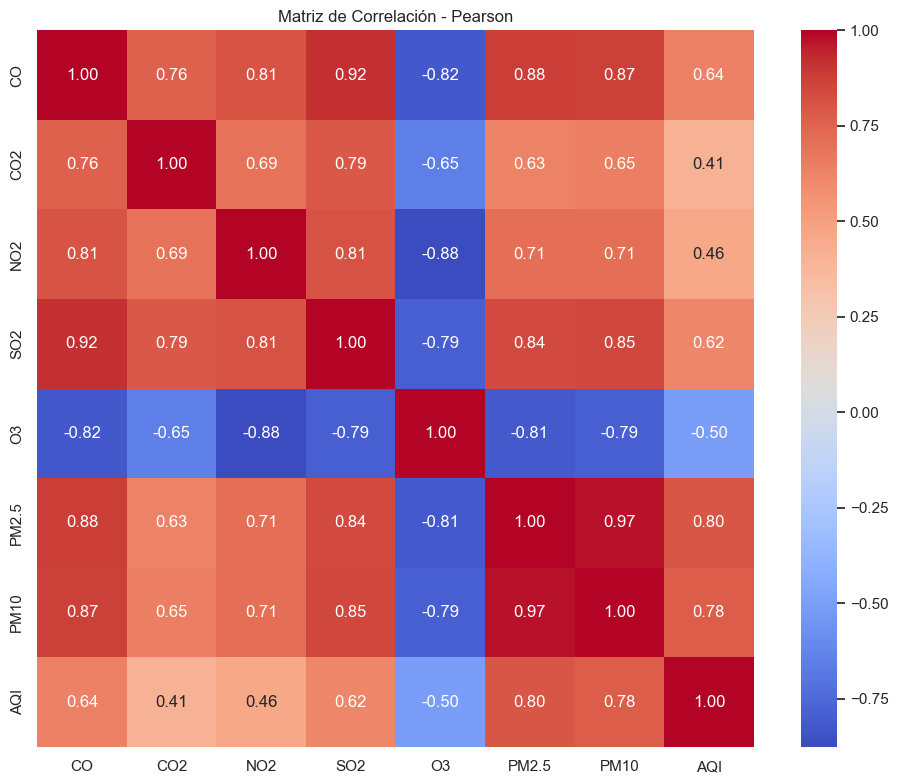


=== Correlación Kendall con AQI ===
AQI      1.000000
PM10     0.420125
PM2.5    0.393826
CO       0.330375
SO2      0.324421
NO2      0.270195
CO2      0.244824
O3      -0.212710
Name: AQI, dtype: float64


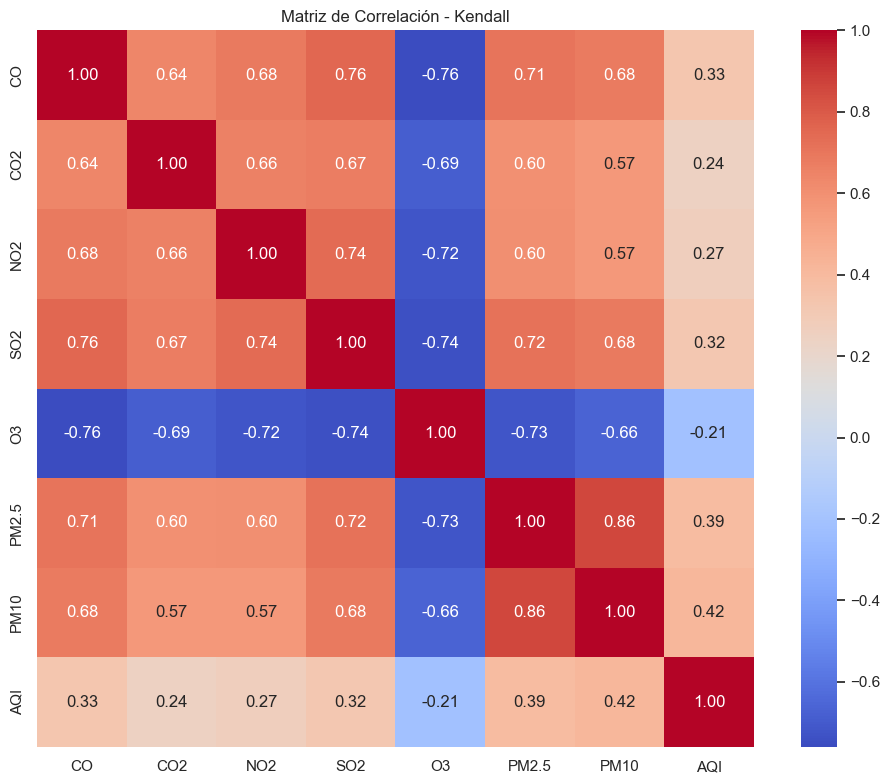

18133

In [6]:
# 1. Crear subconjunto sin NaN en CO2
df_corr_check = df.dropna(subset=["CO2"]).dropna()

# 2. Pearson
corr_pearson = df_corr_check.corr(numeric_only=True, method='pearson')
print("=== Correlación Pearson con AQI ===")
print(corr_pearson["AQI"].sort_values(ascending=False))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación - Pearson")
plt.tight_layout()
plt.show()

# 3. Kendall
corr_kendall = df_corr_check.corr(numeric_only=True, method='kendall')
print("\n=== Correlación Kendall con AQI ===")
print(corr_kendall["AQI"].sort_values(ascending=False))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_kendall, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación - Kendall")
plt.tight_layout()
plt.show()

# 4. Limpiar datasets temporales
del df_corr_check, corr_pearson, corr_kendall
gc.collect()

In [7]:
# Eliminamos CO2
df = df.drop(columns=["CO2"])
print(df.shape, list(df.columns))

(8784, 7) ['CO', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10', 'AQI']


=== Correlación Pearson con AQI ===
AQI      1.000000
PM2.5    0.530098
PM10     0.508481
CO       0.402463
SO2      0.344041
NO2      0.250129
O3       0.042733
Name: AQI, dtype: float64


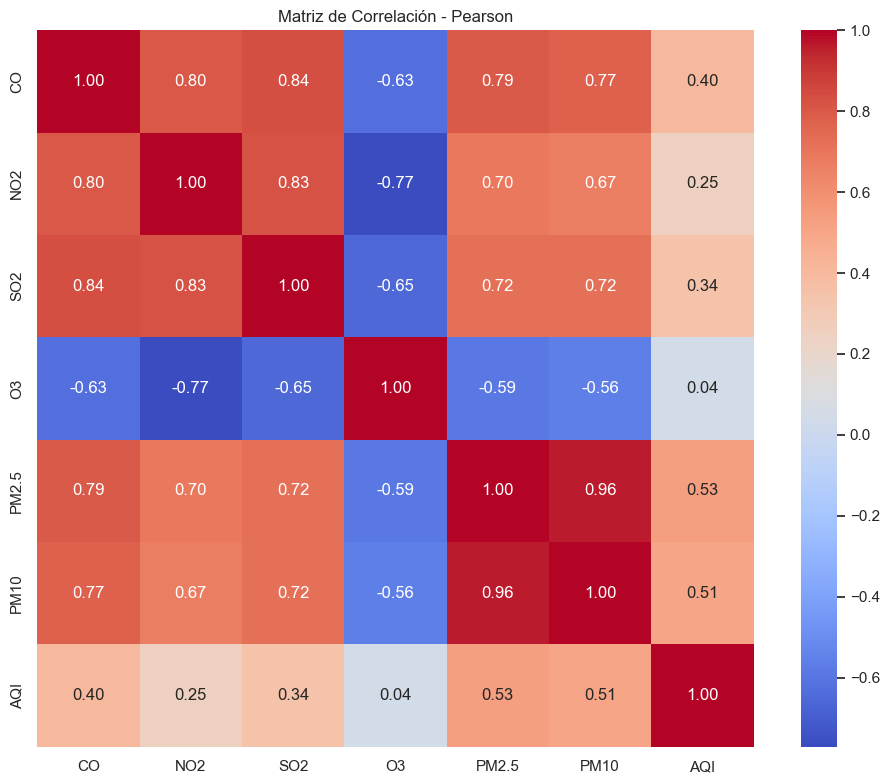


=== Correlación Kendall con AQI ===
AQI      1.000000
O3       0.320960
PM10     0.166565
PM2.5    0.155811
CO       0.149148
SO2      0.088853
NO2      0.005999
Name: AQI, dtype: float64


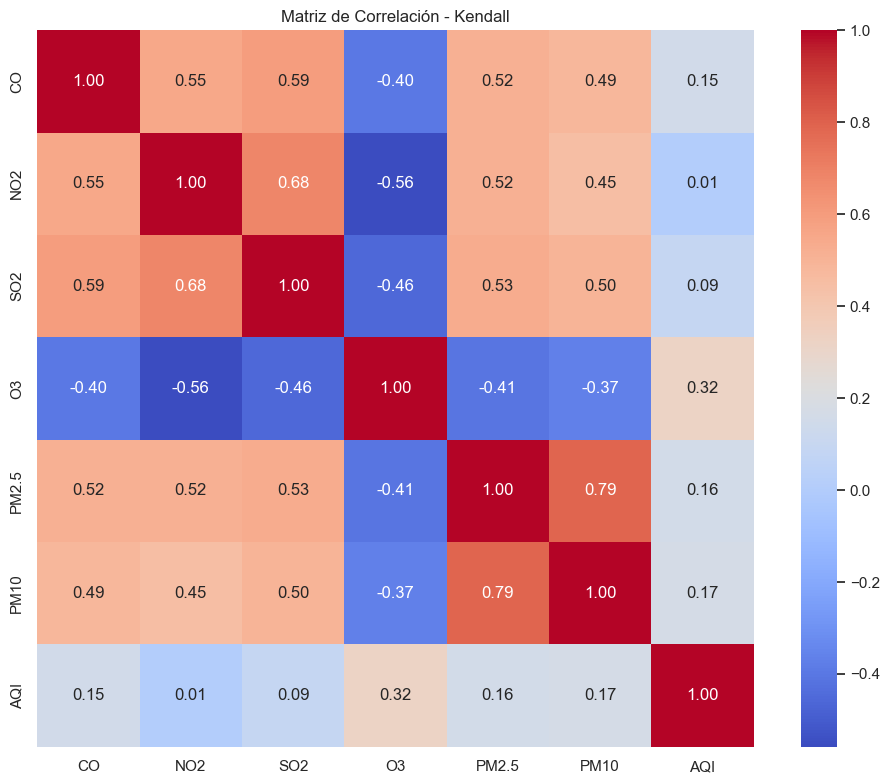

16063

In [8]:
# 1. Crear subconjunto
df_corr_check = df.copy()

# 2. Pearson
corr_pearson = df_corr_check.corr(numeric_only=True, method='pearson')
print("=== Correlación Pearson con AQI ===")
print(corr_pearson["AQI"].sort_values(ascending=False))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación - Pearson")
plt.tight_layout()
plt.show()

# 3. Kendall
corr_kendall = df_corr_check.corr(numeric_only=True, method='kendall')
print("\n=== Correlación Kendall con AQI ===")
print(corr_kendall["AQI"].sort_values(ascending=False))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_kendall, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación - Kendall")
plt.tight_layout()
plt.show()

# 4. Limpiar datasets temporales
del df_corr_check, corr_pearson, corr_kendall
gc.collect()

In [9]:
pcorr = pg.partial_corr(data=df, x='PM2.5', y='AQI', covar='PM10', method='spearman')
print("Correlación parcial PM2.5 vs AQI (controlando PM10):")
print(pcorr)
print("-" * 50)
del pcorr
gc.collect

Correlación parcial PM2.5 vs AQI (controlando PM10):
             n         r          CI95%     p-val
spearman  8784  0.012388  [-0.01, 0.03]  0.245716
--------------------------------------------------


<function gc.collect(generation=2)>

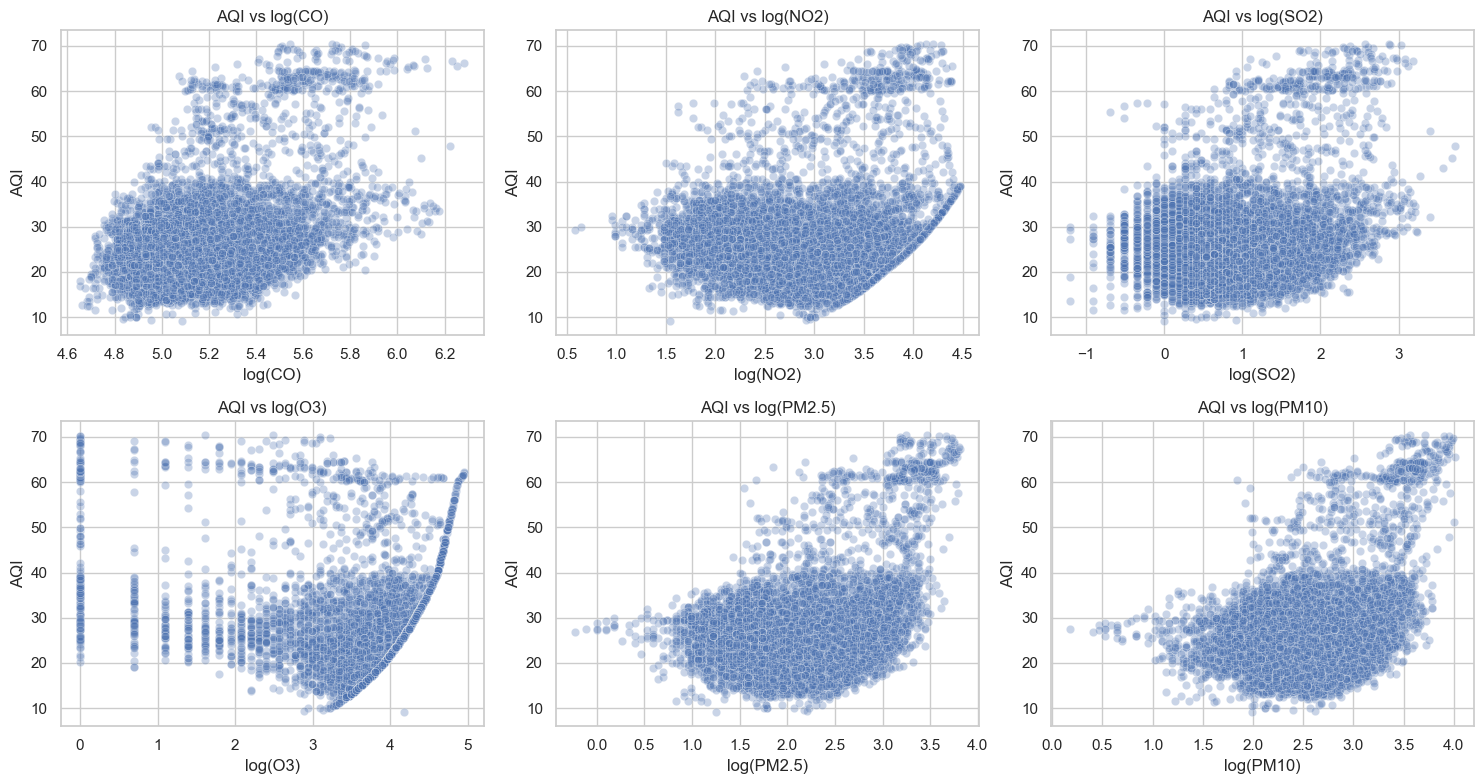

164

In [10]:
predictoras = df.columns.drop("AQI")

# Crear subplots
n = len(predictoras)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(predictoras, 1):
    plt.subplot(n_rows, n_cols, i)
    
    # Filtramos valores positivos para aplicar log
    valid = df[col] > 0
    x_log = np.log(df.loc[valid, col])
    y_vals = df.loc[valid, "AQI"]
    
    sns.scatterplot(x=x_log, y=y_vals, alpha=0.3)
    plt.title(f"AQI vs log({col})")
    plt.xlabel(f"log({col})")
    plt.ylabel("AQI")

plt.tight_layout()
plt.show()

del predictoras, n, n_cols, n_rows
gc.collect()

# Decidimos eliminar el CO2 por su bajo efecto sobre la predicción

# Boxplot de todas las variables
dfCO = df[['CO','CO2']].copy()
dfOTHERS = df.drop(columns=['CO','CO2']).copy()
df_melted1 = dfCO.melt(var_name='Variable', value_name='Valor')
df_melted2 = dfOTHERS.melt(var_name='Variable', value_name='Valor')
fig = px.box(df_melted1, x='Variable', y='Valor', title='Boxplot de las Variables',
             labels={'Valor': 'Valor', 'Variable': 'Variable'},
             points='all', color='Variable'
             )
# save as png
fig.write_image("graficos/boxplot_CO_CO2.png")  # Save the figure as a PNG file
fig.show()
fig2 = px.box(df_melted2, x='Variable', y='Valor', title='Boxplot de las Variables',
             labels={'Valor': 'Valor', 'Variable': 'Variable'},
             points='all', color='Variable'
             )
fig2.write_image("graficos/boxplot_others.png")  # Save the figure as a PNG file
fig2.show()

C:\Users\diego\AppData\Local\Temp\ipykernel_9736\1205739710.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Variable', y='Valor', data=df_melt, palette='Set2')
C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-p

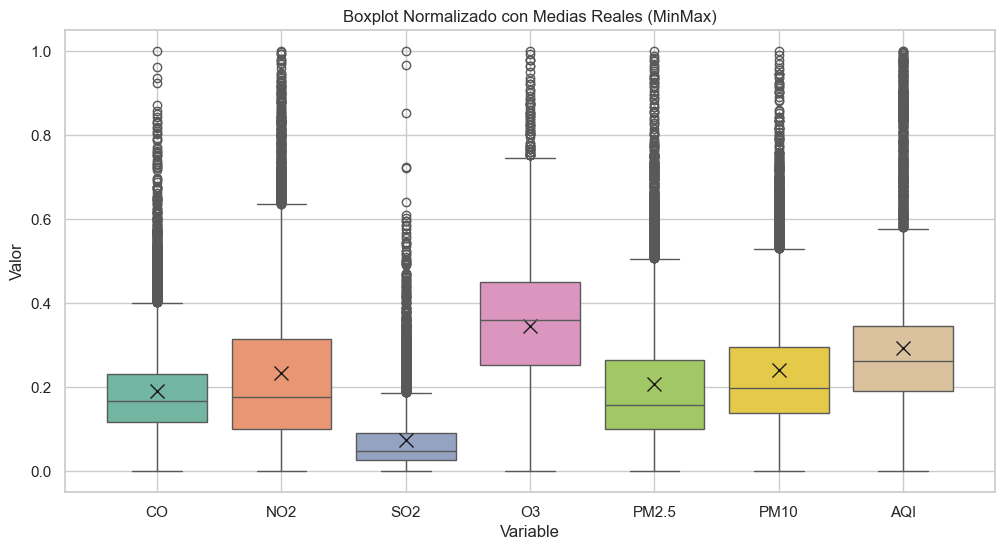

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Normalización
df_scaled = df.copy()
scaler = MinMaxScaler()
df_scaled[df.columns] = scaler.fit_transform(df[df.columns])

# Melt
df_melt = df_scaled.melt(var_name='Variable', value_name='Valor')

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Variable', y='Valor', data=df_melt, palette='Set2')

# Agregar medias reales (escaladas)
for i, var in enumerate(df.columns):
    media = df[var].mean()
    media_scaled = scaler.transform([[media if c == var else df[c].mean() for c in df.columns]])[0][i]
    plt.plot(i, media_scaled, 'kx', markersize=10)

plt.title("Boxplot Normalizado con Medias Reales (MinMax)")
plt.grid(True)
plt.show()

In [ ]:
from plotly import graph_objects as go
n = len(df.columns)
# Determinar cantidad de filas y columnas para la grilla
n_cols = 4
n_rows = (n + 1) // n_cols

fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=df.columns.tolist())
# Agregar cada histograma
for i, col in enumerate(df.columns):
    data_col = df[col].dropna()
    bins_sturges = int(np.ceil(np.log2(len(data_col)) + 1))

    row = i // n_cols + 1
    col_pos = i % n_cols + 1
    fig.add_trace(go.Histogram(x=data_col, nbinsx=bins_sturges, name=col), row=row, col=col_pos)

fig.update_layout(title_text='Histogramas de las variables',
                  height=300 * n_rows,
                  showlegend=False)
fig.write_image("graficos/histogramas_variables.png") 
fig.show()